## Synthetic Financial Datasets For Fraud Detection

This fraud detection exercise is based on this kaggle competition
https://www.kaggle.com/ntnu-testimon/paysim1

The details are here: https://github.com/tritab/amazon-sagemaker-architecting-for-ml/blob/master/Writeups/Anomaly%20Detection%20for%20Credit%20Card%20Fraud.md

The doc for Random Cut Forest (rcf) is available here: https://sagemaker.readthedocs.io/en/stable/randomcutforest.html

In [2]:
import pandas as pd
import boto3
import botocore
%matplotlib inline

In [3]:
bucket = "scientist-13-jon"
key = "anomaly/PS_20174392719_1491204439457_log.csv.zip"

s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file(key, "crimes.csv.zip")

I called this crimes.csv, since crime is a financial crime. Or, I am guilty of a lazy copy/paste. You decide :)

We want to explore the data to become familar with it.

In [4]:
df = pd.read_csv("crimes.csv.zip")

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
df.shape

(6362620, 11)

There are 6,362,620 rows

In [8]:
df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### isFlaggedFraud


There are 8213 records flagged as "isFraud"

In [9]:
df["isFlaggedFraud"].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [11]:
len(df.loc[df.amount > 200000])

1673570

## isFlaggedFraud thought process
The isFlaggedFraud column doesn't appear to be very useful or based on any pattern we can discern. It is also unbalanced (16/6+ million records). In addition, in the description it claims to be based on transactions greater than 200,000, but this is not accurate. Let's drop it.

In [12]:
headers = list(df)

In [13]:
headers

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

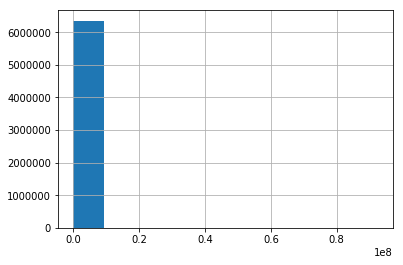

In [15]:
df.amount.hist(bins=10)

## We wanted to get a feeling of the distribution of the amount column, but the histogram didn't behave as we expected, so we switched to descriptive stats

In [21]:
df.amount.describe().apply(lambda x: format(x, 'f'))

count     6362620.000000
mean       179861.903549
std        603858.231463
min             0.000000
25%         13389.570000
50%         74871.940000
75%        208721.477500
max      92445516.640000
Name: amount, dtype: object

In [33]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

There are no missing values, so lets save this and start feature engineering